In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.impute import SimpleImputer

In [44]:
df = pd.read_csv("heart.csv")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [46]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical Columns:", categorical_columns)
print("Continuous Columns:", continuous_columns)

Categorical Columns: []
Continuous Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


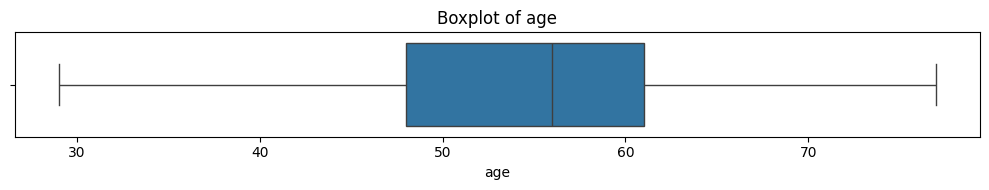

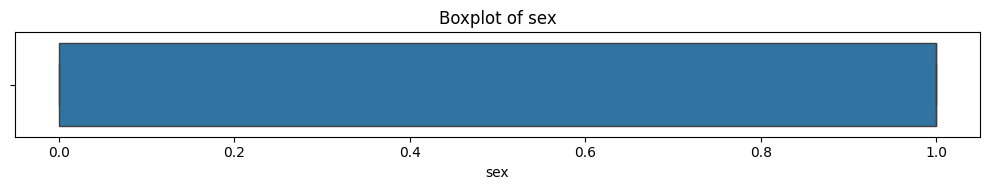

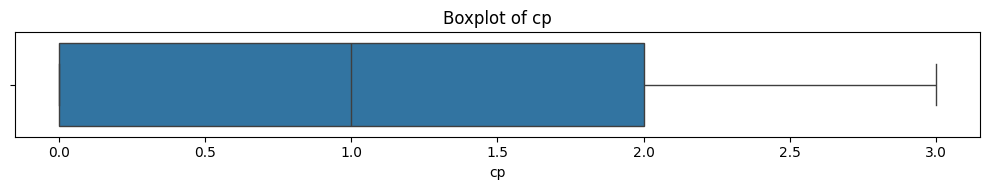

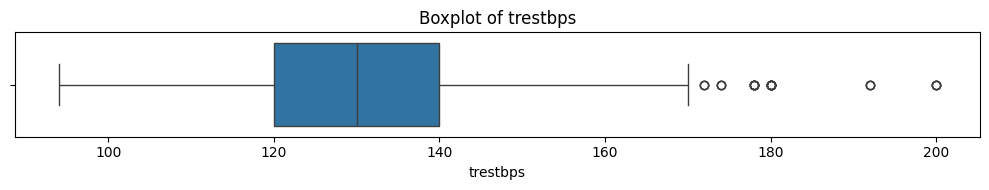

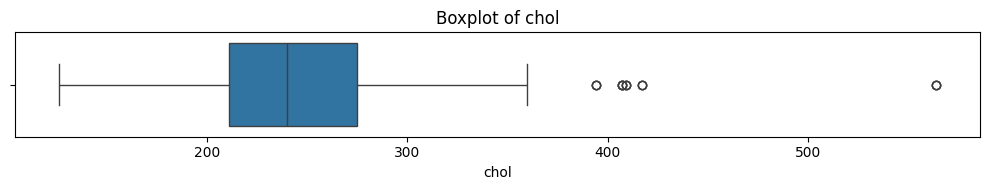

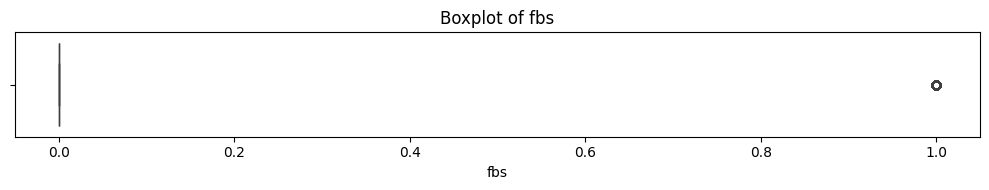

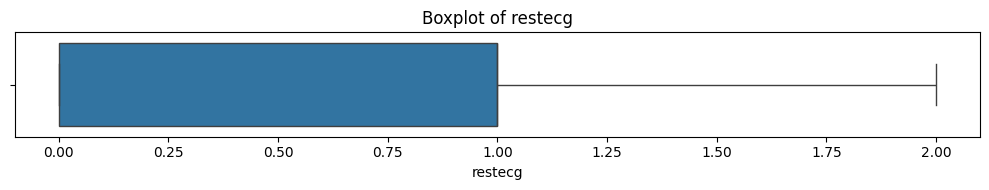

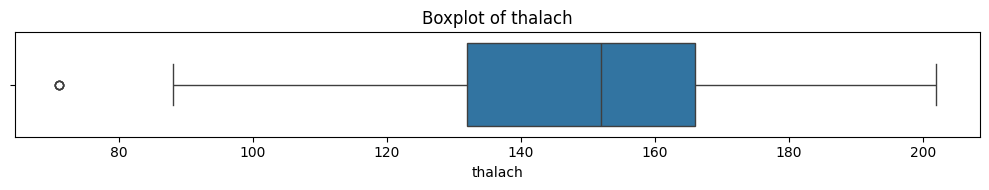

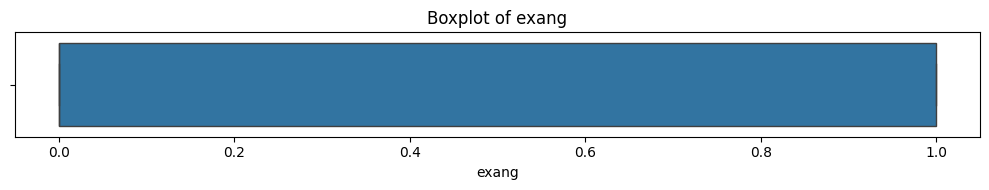

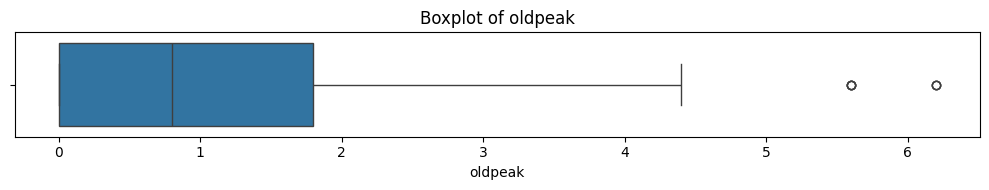

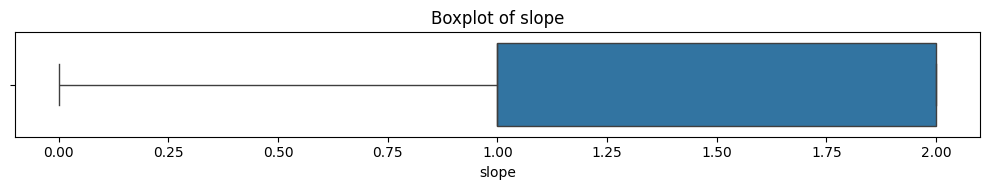

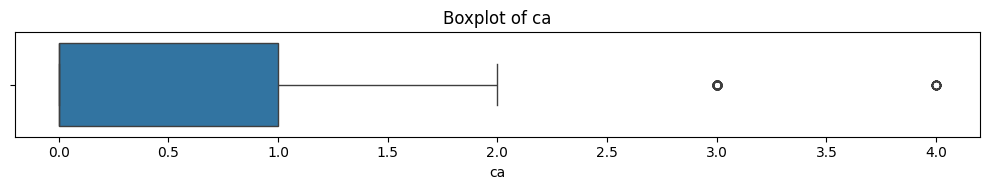

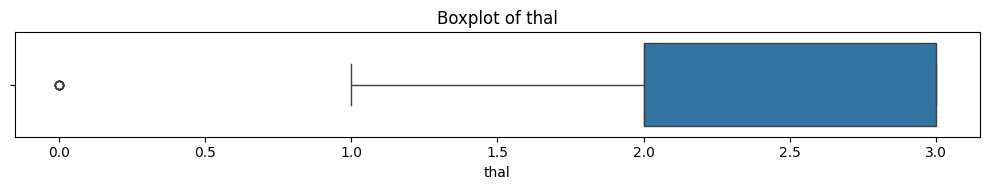

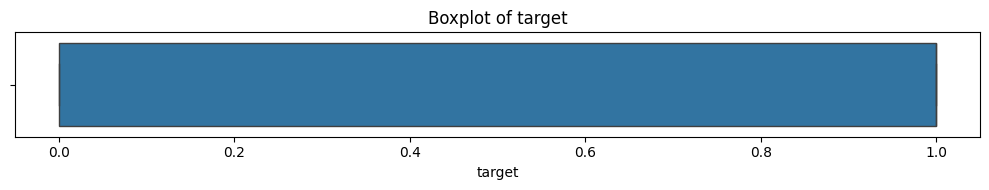

In [47]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'Unnamed: 32':
        plt.figure(figsize=(10, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

In [48]:
# Removal of outliers using z_score

from scipy import stats
X = df.select_dtypes(include=['float64', 'int64'])
y = df['target']
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X_filtered = X[filtered_entries]
y_filtered = y[filtered_entries]
print(f"Original number of samples: {len(X)}")
print(f"Number of samples after outlier removal: {len(X_filtered)}")

Original number of samples: 1025
Number of samples after outlier removal: 969


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and label (using filtered data)
X = X_filtered
y = y_filtered

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_scaled: (775, 14)
Shape of X_test_scaled: (194, 14)
Shape of y_train: (775,)
Shape of y_test: (194,)


In [50]:
#Train a Decision Tree Classifier and visualize the tree.

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [58]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

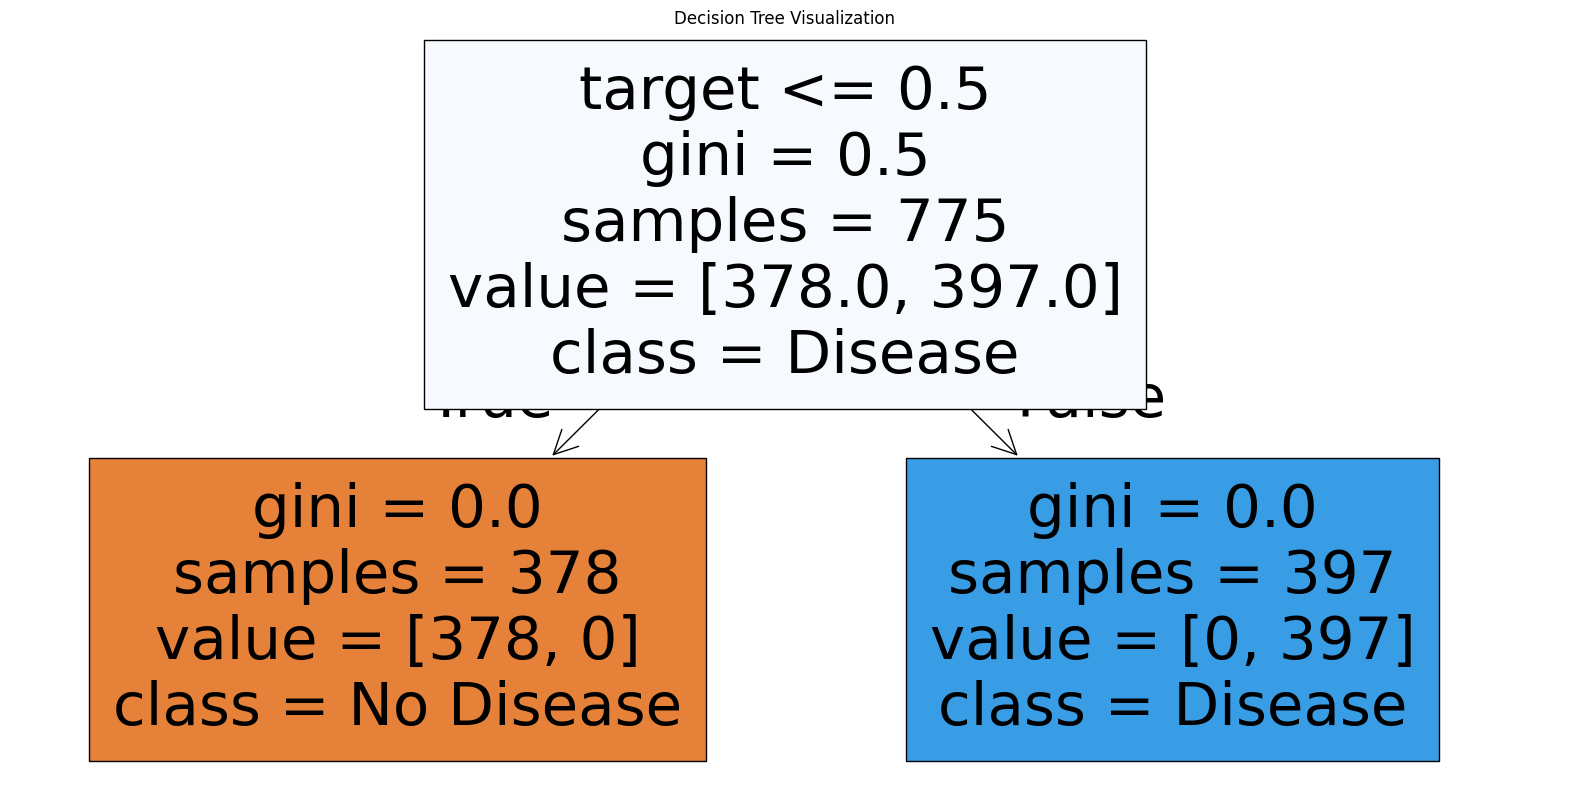

In [59]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=["No Disease", "Disease"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

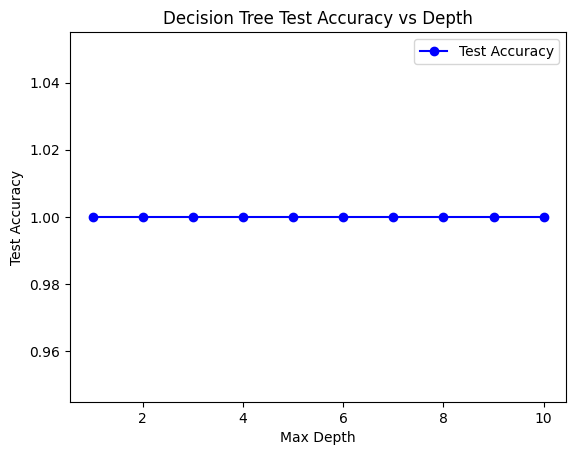

In [61]:
#Analyze Overfitting (Only Test Accuracy)

test_scores = [DecisionTreeClassifier(max_depth=d, random_state=42).fit(X_train, y_train).score(X_test, y_test) for d in range(1, 11)]
plt.plot(range(1, 11), test_scores, marker='o', color='blue', label='Test Accuracy')
plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy")
plt.title("Decision Tree Test Accuracy vs Depth")
plt.legend()
plt.show()


In [54]:
#Train a Random Forest and compare accuracy

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions

dt_acc = accuracy_score(y_test, dt_model.predict(X_test))
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
print("Decision Tree Accuracy:", round(dt_acc, 4))
print("Random Forest Accuracy:", round(rf_acc, 4))


Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0


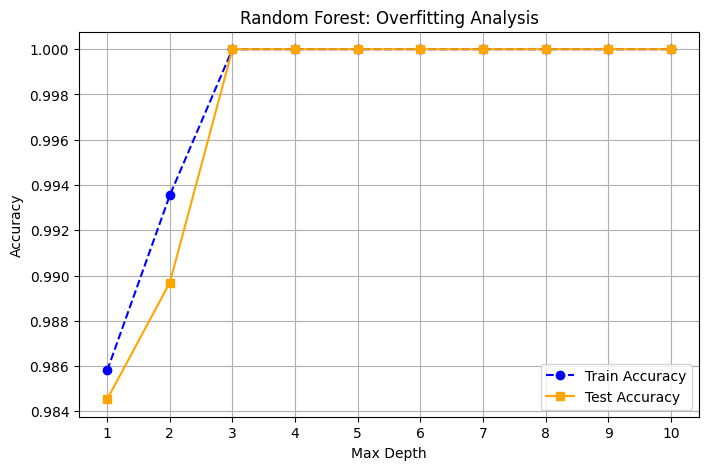

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Lists to store accuracy values
rf_train_scores = []
rf_test_scores = []
depths = range(1, 11)

# Train Random Forests with varying max_depth
for depth in depths:
    rf = RandomForestClassifier(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    rf_train_scores.append(rf.score(X_train, y_train))
    rf_test_scores.append(rf.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(depths, rf_train_scores, marker='o', linestyle='--', color='blue', label='Train Accuracy')
plt.plot(depths, rf_test_scores, marker='s', linestyle='-', color='orange', label='Test Accuracy')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Random Forest: Overfitting Analysis")
plt.xticks(depths)
plt.grid(True)
plt.legend()
plt.show()



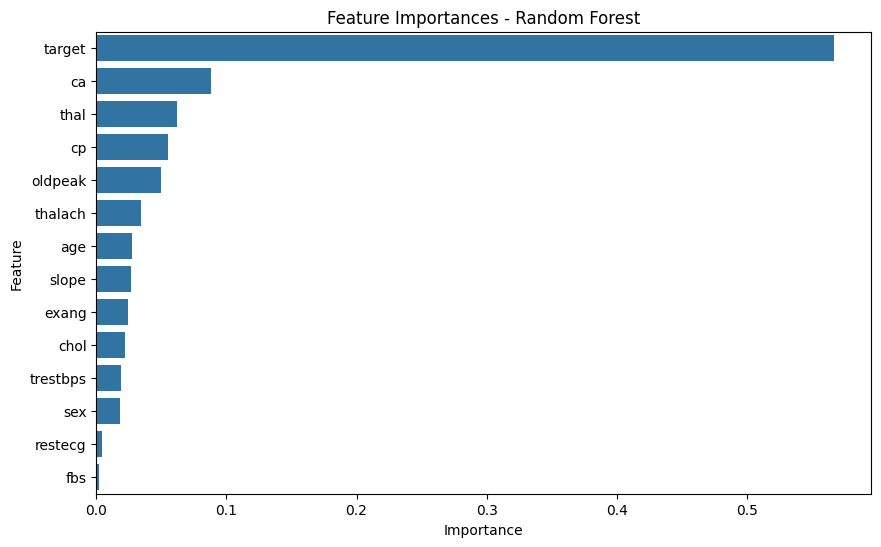

In [56]:
# Feature Importances

importances = rf_model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title("Feature Importances - Random Forest")
plt.show()


In [57]:
#Evaluate using Cross-Validation

from sklearn.model_selection import cross_val_score
dt_cv_score = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, cv=5).mean()
rf_cv_score = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5).mean()
print("Decision Tree Cross-Validation Accuracy:", round(dt_cv_score, 4))
print("Random Forest Cross-Validation Accuracy:", round(rf_cv_score, 4))

Decision Tree Cross-Validation Accuracy: 1.0
Random Forest Cross-Validation Accuracy: 1.0
